In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
folder_path1 = 'data'
folder_path2 = 'figures'
folder_path3 = 'models'

if not os.path.exists(folder_path1):
    os.makedirs(folder_path1)
if not os.path.exists(folder_path2):
    os.makedirs(folder_path2)
if not os.path.exists(folder_path3):
    os.makedirs(folder_path3)

In [2]:
from observable import jackknife,jackknife_stats,grab,compute_autocorrelation,compute_ess

In [3]:
L = 16
def wilson_loop(lattice, x, y):
    U1 = np.exp(1j * lattice[x, y, 0])
    U2 = np.exp(1j * lattice[x, (y + 1) % L, 0])
    U3 = np.exp(1j * lattice[(x + 1) % L, y, 1])
    U4 = np.exp(1j * lattice[x, y, 1])
    return np.real(U1 * U3 * np.conj(U2) * np.conj(U4))

def calculate_angle(array1,xp,yp):
    right = array1[xp % L, yp % L][0]
    up = array1[(xp + 1) % L, yp % L][1]
    down = array1[xp % L, yp % L][1]
    left = array1[xp % L, (yp + 1) % L][0]
    return right + up - left - down

def project_angle(angle):
    return np.remainder(angle+np.pi, (2 * np.pi)) - np.pi

def calculate_topological_charge(array):
    top_charge = 0
    for i in range(L):
        for j in range(L):
            angle = calculate_angle(array, i, j)
            top_charge += project_angle(angle)

    return round(top_charge / (2 * np.pi))



def topological_suspectiblity(array):
    top_charge = 0
    for i in range(L):
        for j in range(L):
            angle = calculate_angle(array, i, j)
            top_charge += project_angle(angle)

    return round(top_charge / (2 * np.pi))**2

def plaq(lat):
    Wilson_loop_values=[]
    lattice_size=lat.shape[2]
    for conf in range(lat.shape[0]):
        wilson_sum = 0
        lattice = lat[conf]
        for x in range(lattice_size):
            for y in range(lattice_size):
                wilson_sum += wilson_loop(lattice, x, y)
        Wilson_loop_values.append(wilson_sum / (lattice_size ** 2))
    return Wilson_loop_values

def wilson_loopij(array, x_len, t_len):
    Wilson_loop_values=[]
    for conf in range(array.shape[0]):
        init = np.zeros((L,L))
        for x in range(x_len):
            init += np.roll(array[conf,:,:,0],-x,axis=0)
        for t in range(t_len):
            init += np.roll(np.roll(array[conf,:,:,1],-x_len,axis=0),-t,axis=1)
        for x in range(x_len):
            init -= np.roll(np.roll(array[conf,:,:,0],(-x_len,-t_len),axis=(0,1)),x+1,axis=0)   
        for t in range(t_len):
            init -= np.roll(np.roll(array[conf,:,:,1],-t_len,axis=1),t+1,axis=1)
        wil_l = np.mean(np.cos(init),axis=(0,1))
        Wilson_loop_values.append(wil_l)
    return Wilson_loop_values

### 1.1 HMC

In [4]:
from tqdm import tqdm
import math

In [5]:
from mc import get_action, get_drift, get_hamiltonian, hmc,gauge_cooling
beta = 1
chains = 10240*3
nk = 1

In [6]:
import copy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm 

filename = 'data/cfgs_L{}_beta{}_{}k.npy'.format(L,beta,nk)

def runhmc(chains):
    local_cfgs = []
    local_acc = []
    for chain_idx in tqdm(range(chains), desc="Chain Progress"):
        phi = np.zeros((L,L,2))
        S = get_action(phi, beta)
        for i in range(all_steps):
            phi, S, accepted = hmc(phi, S, beta)
            local_acc.append(accepted)
            phi = gauge_cooling(phi)
            if i % eq_step == 0 and i > therm_step:
                local_cfgs.append(copy.deepcopy(phi))
    return local_cfgs

if os.path.exists(filename):
    print('load from file') 
    cfgs = np.load(filename,allow_pickle=True)

else:
    
    print('generating new cfgs')
    therm_step = 200
    eq_step = 128
    all_steps = (therm_step + eq_step)
    
    # prepare training data-set
    chainlist = list(chains for i in range(nk))
    max_workers = 0  # Set this variable to control the number of workers

    if max_workers > 1:
        # Use multiprocessing when more than 1 worker is specified
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(runhmc, chainlist))
    else:
        
        # Execute serially without multiprocessing
        results = [runhmc(chains) for i in range(nk)]
        

    # Accumulating and reshaping results
    all_cfgs = [cfg for sublist in results for cfg in sublist]
    cfgs = np.array(all_cfgs).reshape(-1, L, L, 2)
    print(cfgs.shape)

    np.save(filename, cfgs)


load from file


In [7]:
cfgs=gauge_cooling(cfgs[:10240*3])

In [8]:
def gauge_trans(lattice,num):
    gauge = (2 * np.random.rand(num, L, L) - 1)*np.pi
    transed = np.random.rand(num, L, L,2)
    transed[:,:,:,0] = lattice[:num,:,:,0] + gauge - np.roll(gauge,-1,axis=1)
    transed[:,:,:,1] = lattice[:num,:,:,1] + gauge - np.roll(gauge,-1,axis=2)
    return transed
    

In [9]:
cool_steps = cfgs.shape[0]
temp = copy.deepcopy(cfgs)

transfered_lattices = []
en_times = 4
for _ in range(en_times):
    temp = gauge_trans(temp, cool_steps)
    cooled_temp = gauge_cooling(temp)
    transfered_lattices.append(cooled_temp)


cfgs = gauge_cooling(cfgs)

cfgs = np.concatenate((cfgs, *transfered_lattices), axis=0)


## 2. Diffusion Models

### 2.1 preparations

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():

  device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_device(device)
else:
  device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_device(device)
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 4080 Laptop GPU


#### 2.1.1 normalization

In [11]:
from norm import norm, renorm

cfgs_nm,cfgs_min,cfgs_max = norm(cfgs)

nm = 1

configs = torch.from_numpy(cfgs_nm).float().permute(0, 3, 1, 2).to(device) # torch tensor
configs.shape

torch.Size([153600, 2, 16, 16])

#### 2.1.2 data set 

In [12]:
from torch.utils.data import Dataset, DataLoader,TensorDataset

n_epochs =   250#@param {'type':'integer'}
## size of a mini-batch
batch_size =  256 #@param {'type':'integer'}
## learning rate
lr=1e-3 #@param {'type':'number'}

num_train = (1+en_times)*cool_steps

dataset = TensorDataset(configs[:num_train], configs[:num_train])
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, generator=torch.Generator(device))#

#### 2.1.3 stochastic differential equations

In [13]:
import functools
from sde import marginal_prob_std, diffusion_coeff

sigma =  25.0#@param {'type':'number'} default = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

### 2.2 Building ScoreNet

In [14]:
import tqdm
from torch.optim import Adam
from loss import loss_fn
import torchvision.transforms as transforms
from unet import GaussianFourierProjection,Dense,ScoreNet

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

### 2.3 Training

In [ ]:

#@title Training (double click to expand or collapse)
n_epochs = 250
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)   
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  if epoch>230:
    torch.save(score_model.state_dict(), 'models/noise_ckpt_L{}_beta{}_num{}_nm{}_epoch{}.pth'.format(L,beta,num_train,nm,epoch))


"\n#@title Training (double click to expand or collapse)\nn_epochs = 250\noptimizer = Adam(score_model.parameters(), lr=lr)\ntqdm_epoch = tqdm.trange(n_epochs)\nfor epoch in tqdm_epoch:\n  avg_loss = 0.\n  num_items = 0\n  for x, y in data_loader:\n    x = x.to(device)   \n    loss = loss_fn(score_model, x, marginal_prob_std_fn)\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n    avg_loss += loss.item() * x.shape[0]\n    num_items += x.shape[0]\n  # Print the averaged training loss so far.\n  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))\n  # Update the checkpoint after each epoch of training.\n  if epoch>230:\n    torch.save(score_model.state_dict(), 'models/noise_ckpt_L{}_beta{}_num{}_nm{}_epoch{}.pth'.format(L,beta,num_train,nm,epoch))\n"

### 2.4 Sampling

In [16]:
model_beta = 1
model_L = 16
ckpt_1 = torch.load(
    'models/noise_ckpt_L{}_beta{}_num153600_nm1_epoch249.pth'.format(model_L, model_beta),
    map_location=device,
    weights_only=True 
)

score_model.load_state_dict(ckpt_1)

<All keys matched successfully>

In [17]:
num_sample = 1024 

from sampler import MALA_sampler
sampler = MALA_sampler
alpha=5e-9
ratio=0.9
t_0=1
size=400
num_steps = 100
target_L = 16
target_beta = 7
#samples, accept rate, accept rate at each noise scale, action list, topological charge list
samples,rate,rate_traj, s_list,Q_list= sampler(score_model, 
                marginal_prob_std_fn,
                diffusion_coeff_fn, 
                batch_size = num_sample, 
                num_steps = num_steps, 
                device=device,
                alpha=alpha,ratio=ratio,mh_steps=400,t_mh=0.001,
                L =16,start=t_0,size=size,beta=target_beta/model_beta)


c:\ProgramData\anaconda3\Lib\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 30/30 [26:06<00:00, 52.22s/it]


### 2.5 Evaluation

In [18]:
all_sample=np.array(samples)
samples=all_sample.reshape(-1,2,L,L)

In [19]:
all_sample.shape

(1024, 2, 16, 16)

In [20]:
samples_re = renorm(samples,cfgs_min,cfgs_max)
cfgs_df = samples_re
cfgs_test = np.transpose(cfgs_df,(0, 2, 3, 1))
cfgs = cfgs[:1024]
cfgs_plaq=wilson_loopij(cfgs,1,1)
cfgs_test_plaq = wilson_loopij(cfgs_test,1,1)

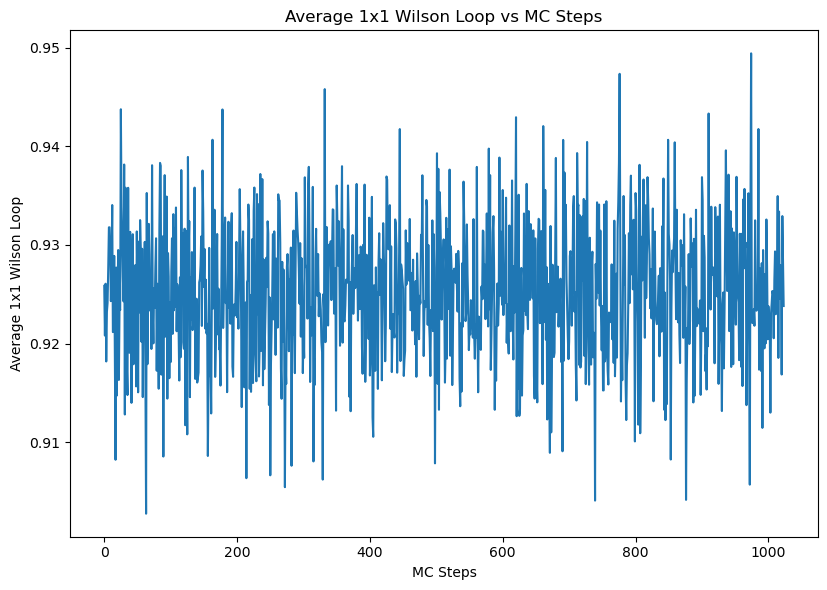

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

plt.plot(np.arange(cfgs_test.shape[0]), cfgs_test_plaq)
plt.title("Average 1x1 Wilson Loop vs MC Steps")
plt.xlabel("MC Steps")
plt.ylabel("Average 1x1 Wilson Loop")

plt.tight_layout()
plt.show()

#### Plaq Hist

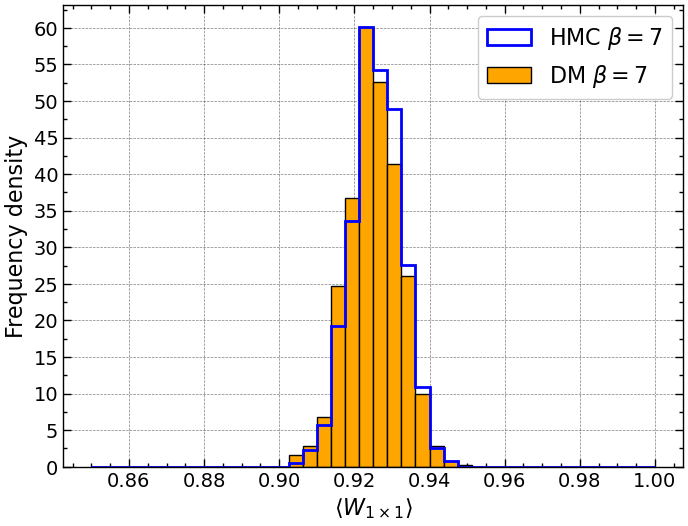

In [28]:
import scienceplots
from matplotlib.ticker import MultipleLocator
plt.style.use(['science', 'notebook','grid'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 14  # 设置横坐标字体大小
plt.rcParams['ytick.labelsize'] = 14  # 设置纵坐标字体大小

plt.figure(figsize=(8, 6))



Xrange=(0.85,1)
plt.hist(cfgs_plaq, bins=40,range=Xrange, histtype='step',linewidth=2,edgecolor='blue',color='blue',alpha=1,density=True,label=r'HMC $\beta = 7$')
plt.hist(cfgs_test_plaq, bins=40,range=Xrange, edgecolor='black',color='orange',alpha=1,density=True, label=r'DM $\beta = 7$')

ax = plt.gca()  
ax.yaxis.set_major_locator(MultipleLocator(5)) 
ax.yaxis.set_minor_locator(MultipleLocator(2.5)) 


plt.legend()

plt.xlabel(r'$\langle W_{1 \times 1} \rangle$', fontsize=16)
plt.ylabel(r'Frequency density', fontsize=16)
plt.savefig('beta_7_Wilson_loop_step.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Wilson loops

In [ ]:
for i in range(1,5):
    print(np.mean(wilson_loopij(cfgs_test[:],i,i)),np.std(wilson_loopij(cfgs_test[:],i,i)))

0.92519704427842975 0.00620574976761201
0.73706997364954174 0.03379398011476174
0.49554813620652594 0.07255679981067424
0.28336750812313477 0.10592245818325528


In [24]:
for i in range(1,5):
    print(np.mean(wilson_loopij(cfgs[:],i,i)),np.std(wilson_loopij(cfgs[:],i,i)))

0.9258483702727198 0.00652802527457644
0.7384604609967504 0.03066239752436074
0.5132801244094619 0.06622602082429403
0.3158275714518931 0.09397229272901812


#### Topological Charge Hist

In [25]:
top_charge_history=[]
top_charge_history2=[]
for conf in range(cfgs_test.shape[0]):
    top_charge_history.append(calculate_topological_charge(cfgs_test[conf]))
    top_charge_history2.append(calculate_topological_charge(cfgs[conf]))

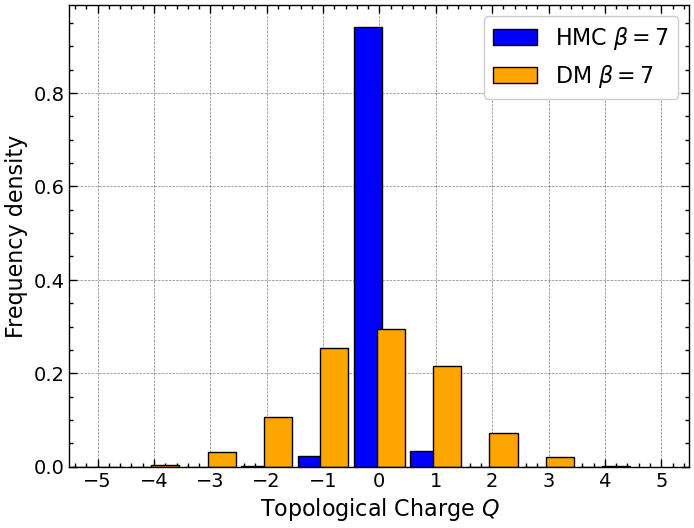

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots


plt.style.use(['science', 'notebook','grid'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14  

fig_width = 8 
fig_height = 6  
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=100)

bin_range = range(-5, 6)

hist2, bins2 = np.histogram(top_charge_history2, bins=bin_range, density=True)
hist, bins = np.histogram(top_charge_history, bins=bin_range, density=True)

ax.bar(bins2[:-1] - 0.2, hist2, width=0.5, edgecolor='black', color='blue', alpha=1, label=r'HMC $\beta=7$')
ax.bar(bins[:-1] + 0.2, hist, width=0.5, edgecolor='black', color='orange', alpha=1, label=r'DM $\beta=7$')

ax.set_xlabel(r'Topological Charge $Q$', fontsize=16)
ax.set_ylabel(r'Frequency density', fontsize=16)
ax.set_xticks(range(-5, 6, 1))

ax.set_xlim(-5.5, 5.5)
#ax.set_ylim(-0.001, 0.3)
plt.legend()


ax = plt.gca()  # 获取当前的坐标轴



plt.legend()

ax = plt.gca()  
ax.yaxis.set_major_locator(MultipleLocator(0.2)) 
ax.yaxis.set_minor_locator(MultipleLocator(0.05))  
plt.savefig('beta_7_Q_new.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


#### Topological Suspectibility

In [ ]:
suspect1 = []
for conf in range(cfgs_test.shape[0]):
    suspect1.append(topological_suspectiblity(cfgs_test[conf]))
mean, err = jackknife_stats(suspect1)
print(mean/L**2,err/L**2)

0.004505157470703125 0.0005369903717622893


In [ ]:
suspect2 = []
for conf in range(cfgs.shape[0]):
    suspect2.append(topological_suspectiblity(cfgs[conf]))
mean2, err2 = jackknife_stats(suspect2)
print(mean2/L**2,err2/L**2)

0.0002365112304687499 3.198772317967985e-05
